# FinGenius: AI Personal Finance Advisor

## Introduction

Welcome to FinGenius, an AI-powered personal finance advisor that helps users analyze their spending patterns, provides personalized financial recommendations, and answers finance-related questions with reliable sources.

This project is my submission for the 5-Day Gen AI Intensive Course Capstone Project. As an IITM BS Data Science student, I've applied the knowledge gained from the course to create a practical solution that demonstrates multiple Gen AI capabilities.

### Problem Statement

Many individuals struggle with managing their finances effectively. They need help with:
- Understanding their spending patterns
- Getting personalized financial advice
- Learning about financial concepts and best practices
- Creating and maintaining budgets
- Planning for financial goals

FinGenius addresses these needs by providing an intelligent assistant that can analyze transaction data, offer personalized recommendations, and answer finance-related questions in a conversational manner.

### Gen AI Capabilities Showcased

This project demonstrates the following Gen AI capabilities:

1. **Structured Output/JSON Mode**: For transaction categorization, budget breakdown, and financial health reports
2. **RAG (Retrieval Augmented Generation)**: For accessing financial knowledge and providing evidence-based recommendations
3. **Embeddings**: For semantic understanding of transactions and finding spending patterns
4. **Function Calling**: For financial calculations and data processing
5. **Agents with LangGraph**: For creating a conversational financial advisor workflow

Let's get started by setting up our environment and implementing these capabilities!

## Setup

First, let's install the necessary libraries for our project.

In [1]:
!pip install -Uq google-genai==1.7.0 chromadb==0.6.3 langgraph==0.3.21 langchain-google-genai==2.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.8 MB/s eta 0:00

### Setting up the Gemini API

We'll use the Gemini API for our generative AI capabilities. Let's set up the API key and client.

In [2]:
import os
import google.generativeai as genai
from google.genai import types
from IPython.display import Markdown, display
from google.colab import userdata


# Set up the API key
genai.configure(api_key=userdata.get("GOOGLE_API_KEY"))
# genai.configure(api_key="")

# Set up the model - using Gemini 2.0 Flash-Lite for better rate limits
model = genai.GenerativeModel('models/gemini-2.0-flash-lite')

# Set up the embedding model
embedding_model = 'models/embedding-001'

# Function to display model responses
def display_response(response):
    if hasattr(response, 'text'):
        display(Markdown(response.text))
    else:
        display(Markdown(response))

### Automated retry for API requests

Let's set up an automatic retry mechanism to handle potential API rate limits.

In [3]:
from google.api_core import retry
import google.api_core.exceptions
import time

# Update the retry logic with exponential backoff for rate limits
is_retriable = lambda e: (isinstance(e, google.api_core.exceptions.ServiceUnavailable) or
                         isinstance(e, google.api_core.exceptions.ResourceExhausted) or
                         isinstance(e, google.api_core.exceptions.TooManyRequests))

# Custom retry decorator with longer delays
def custom_retry(func):
    def wrapper(*args, **kwargs):
        max_retries = 5
        retry_count = 0
        while retry_count < max_retries:
            try:
                return func(*args, **kwargs)
            except Exception as e:
                if is_retriable(e) and retry_count < max_retries - 1:
                    wait_time = 2 ** retry_count  # Exponential backoff
                    print(f"Rate limit hit. Waiting {wait_time} seconds before retry...")
                    time.sleep(wait_time)
                    retry_count += 1
                else:
                    raise
    return wrapper

# Apply the custom retry to generate_content
if not hasattr(genai.GenerativeModel.generate_content, '__wrapped__'):
    genai.GenerativeModel.generate_content = custom_retry(genai.GenerativeModel.generate_content)

## 1. Creating Sample Financial Data

Let's create a sample dataset of financial transactions that we'll use throughout this project.

In [4]:
import pandas as pd
import numpy as np
import datetime
import random

# Set a random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Define categories and sample merchants
categories = {
    'Groceries': ['Whole Foods', 'Trader Joe\'s', 'Safeway', 'Kroger', 'Walmart', 'Target'],
    'Dining': ['Starbucks', 'Chipotle', 'McDonald\'s', 'Subway', 'Pizza Hut', 'Local Restaurant'],
    'Transportation': ['Uber', 'Lyft', 'Gas Station', 'Public Transit', 'Car Repair', 'Parking'],
    'Shopping': ['Amazon', 'Best Buy', 'Macy\'s', 'Nike', 'Apple Store', 'Home Depot'],
    'Entertainment': ['Netflix', 'Spotify', 'Movie Theater', 'Concert Tickets', 'Hulu', 'Disney+'],
    'Utilities': ['Electric Bill', 'Water Bill', 'Internet Provider', 'Phone Bill', 'Gas Bill', 'Trash Service'],
    'Housing': ['Rent Payment', 'Mortgage Payment', 'Home Insurance', 'Furniture Store', 'Home Repair'],
    'Healthcare': ['Pharmacy', 'Doctor Visit', 'Dental Checkup', 'Health Insurance', 'Gym Membership'],
    'Education': ['Tuition', 'Textbooks', 'Online Course', 'School Supplies', 'Student Loan Payment'],
    'Income': ['Salary Deposit', 'Freelance Payment', 'Tax Refund', 'Investment Dividend', 'Gift']
}

# Define typical amount ranges for each category
amount_ranges = {
    'Groceries': (30, 200),
    'Dining': (10, 100),
    'Transportation': (5, 150),
    'Shopping': (20, 500),
    'Entertainment': (10, 100),
    'Utilities': (50, 300),
    'Housing': (800, 2500),
    'Healthcare': (20, 500),
    'Education': (50, 1000),
    'Income': (1000, 5000)
}

# Generate 3 months of transactions
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=90)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create empty lists to store transaction data
dates = []
descriptions = []
amounts = []
true_categories = []  # We'll use this for evaluation later

# Generate transactions
for date in date_range:
    # Number of transactions for this day (1-5)
    num_transactions = random.randint(1, 5)

    for _ in range(num_transactions):
        # Select a random category
        category = random.choice(list(categories.keys()))

        # Select a random merchant from that category
        merchant = random.choice(categories[category])

        # Generate a random amount based on the category
        min_amount, max_amount = amount_ranges[category]
        amount = round(random.uniform(min_amount, max_amount), 2)

        # For income, make the amount positive; for expenses, make it negative
        if category != 'Income':
            amount = -amount

        # Add to our lists
        dates.append(date)
        descriptions.append(merchant)
        amounts.append(amount)
        true_categories.append(category)

# Create a DataFrame
transactions_df = pd.DataFrame({
    'Date': dates,
    'Description': descriptions,
    'Amount': amounts,
    'Category': true_categories
})

# Sort by date
transactions_df = transactions_df.sort_values('Date').reset_index(drop=True)

# Display the first few transactions
transactions_df.head()

,Date,Description,Amount,Category
0,2025-01-08 12:25:12.021529,Target,-76.75,Groceries
1,2025-01-09 12:25:12.021529,Parking,-19.86,Transportation
2,2025-01-09 12:25:12.021529,Tuition,-610.97,Education
3,2025-01-10 12:25:12.021529,Whole Foods,-67.17,Groceries
4,2025-01-11 12:25:12.021529,Salary Deposit,3244.98,Income


Let's visualize the distribution of transactions by category to get a better understanding of our data.

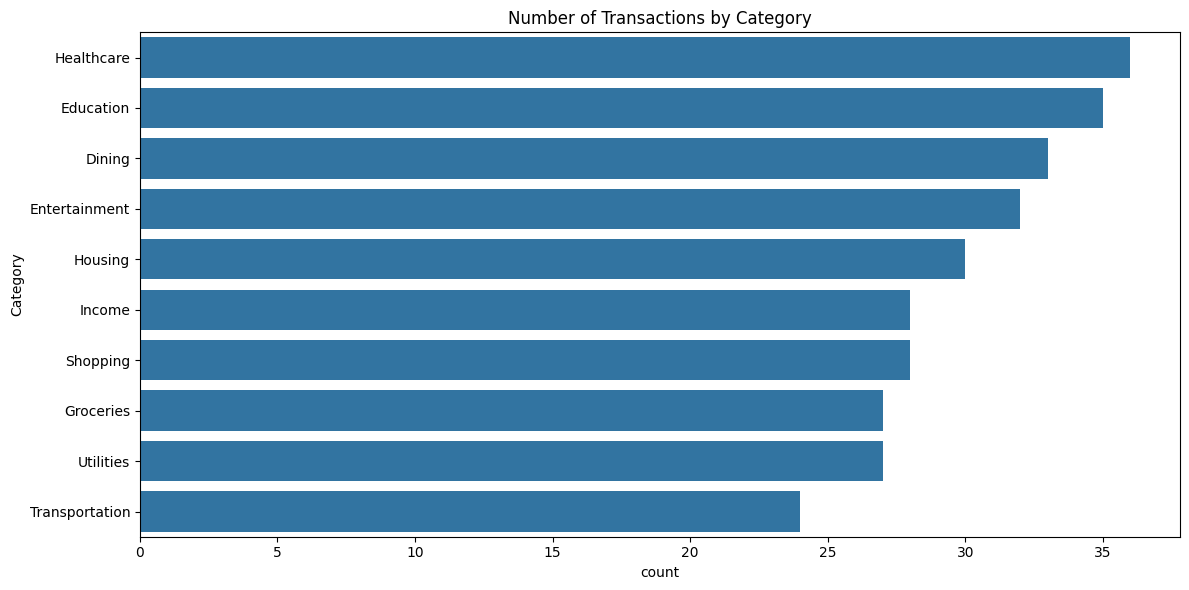

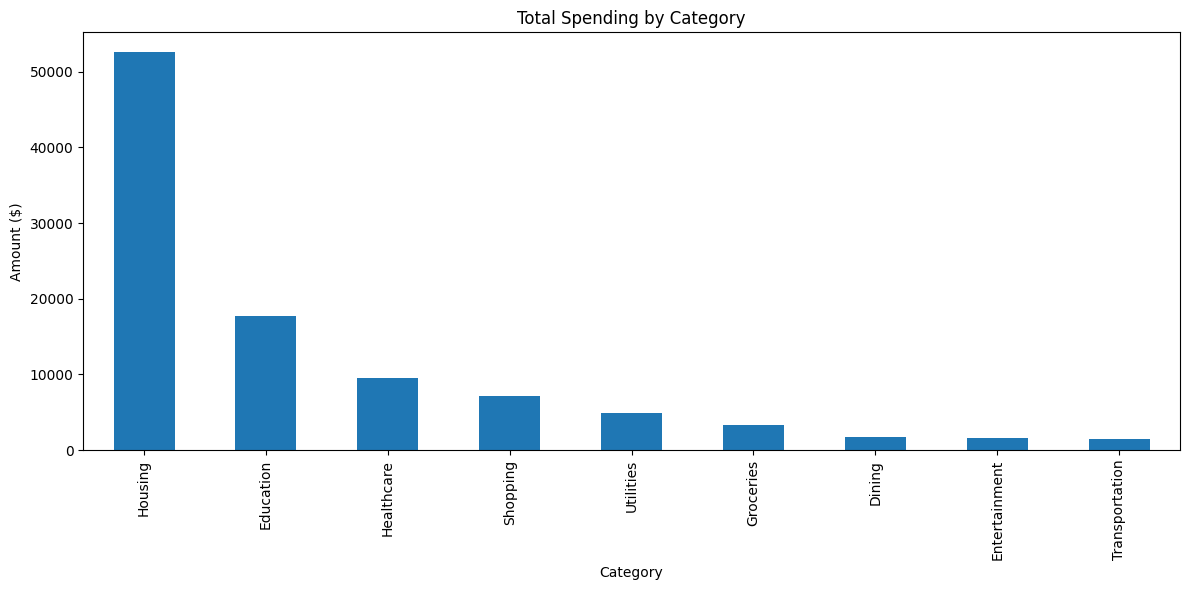

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(y='Category', data=transactions_df, order=transactions_df['Category'].value_counts().index)
plt.title('Number of Transactions by Category')
plt.tight_layout()
plt.show()

# Create a DataFrame for spending by category (excluding income)
spending_by_category = transactions_df[transactions_df['Amount'] < 0].groupby('Category')['Amount'].sum().abs().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
spending_by_category.plot(kind='bar')
plt.title('Total Spending by Category')
plt.ylabel('Amount ($)')
plt.tight_layout()
plt.show()

## 2. Capability 1: Structured Output for Transaction Categorization

One of the key challenges in personal finance management is correctly categorizing transactions. Let's use the Gemini API's structured output capability to automatically categorize transactions based on their descriptions.

In [6]:
# Define the schema for transaction categorization
transaction_schema = {
    "type": "object",
    "properties": {
        "category": {
            "type": "string",
            "description": "The category of the transaction",
            "enum": list(categories.keys())
        },
        "confidence": {
            "type": "number",
            "description": "Confidence score between 0 and 1"
        },
        "reasoning": {
            "type": "string",
            "description": "Explanation for the categorization"
        }
    },
    "required": ["category", "confidence", "reasoning"]
}

In [7]:
import json

def categorize_transaction(description, amount):
    prompt = f"""
    You are a financial transaction categorizer. Categorize the following transaction into one of these categories:
    {', '.join(categories.keys())}

    Transaction: {description}
    Amount: ${abs(amount):.2f} {'spent' if amount < 0 else 'received'}

    Provide your response as a JSON object with the following properties:
    - category: The most appropriate category from the list
    - confidence: A number between 0 and 1 indicating your confidence in this categorization
    - reasoning: A brief explanation of why you chose this category
    """

    # For google-genai, we need to use a different approach for structured output
    response = model.generate_content(prompt)

    # Extract JSON from the response
    try:
        # Look for JSON in the response text
        response_text = response.text
        # Find JSON content between curly braces
        json_start = response_text.find('{')
        json_end = response_text.rfind('}')
        if json_start != -1 and json_end != -1:
            json_str = response_text[json_start:json_end+1]
            result = json.loads(json_str)
            return result
        else:
            # If no JSON found, create a default response
            return {
                "category": "Shopping" if amount < 0 else "Income",
                "confidence": 0.5,
                "reasoning": "Default categorization based on amount"
            }
    except Exception as e:
        print(f"Error parsing response: {e}")
        print(f"Response text: {response.text}")
        # Return a default response
        return {
            "category": "Shopping" if amount < 0 else "Income",
            "confidence": 0.5,
            "reasoning": "Default categorization due to parsing error"
        }

In [8]:
# Test the categorization function on a few examples
test_transactions = [
    ("Whole Foods", -85.42),
    ("Netflix", -15.99),
    ("Uber", -24.50),
    ("Salary Deposit", 3500.00),
    ("Doctor Visit", -150.00)
]

for desc, amount in test_transactions:
    result = categorize_transaction(desc, amount)
    print(f"Transaction: {desc}, Amount: ${abs(amount):.2f} {'spent' if amount < 0 else 'received'}")
    print(f"Categorized as: {result['category']} (Confidence: {result['confidence']:.2f})")
    print(f"Reasoning: {result['reasoning']}")
    print("-" * 80)

Transaction: Whole Foods, Amount: $85.42 spent
Categorized as: Groceries (Confidence: 0.95)
Reasoning: Whole Foods is a grocery store, so purchases there are almost certainly groceries.
--------------------------------------------------------------------------------
Transaction: Netflix, Amount: $15.99 spent
Categorized as: Entertainment (Confidence: 0.95)
Reasoning: Netflix is a streaming service providing movies and TV shows, which falls under the entertainment category.
--------------------------------------------------------------------------------
Transaction: Uber, Amount: $24.50 spent
Categorized as: Transportation (Confidence: 0.95)
Reasoning: Uber is a ride-sharing service, which falls under the transportation category.
--------------------------------------------------------------------------------
Transaction: Salary Deposit, Amount: $3500.00 received
Categorized as: Income (Confidence: 1.00)
Reasoning: This transaction represents a salary deposit, which is the direct receip

Now let's apply this categorization to a subset of our transactions and evaluate the accuracy.

In [9]:
# Take a sample of transactions for evaluation
sample_size = 20
sample_df = transactions_df.sample(sample_size, random_state=42).copy()

# Apply categorization
predicted_categories = []
confidences = []
reasonings = []

for _, row in sample_df.iterrows():
    result = categorize_transaction(row['Description'], row['Amount'])
    predicted_categories.append(result['category'])
    confidences.append(result['confidence'])
    reasonings.append(result['reasoning'])

sample_df['Predicted_Category'] = predicted_categories
sample_df['Confidence'] = confidences
sample_df['Reasoning'] = reasonings
sample_df['Correct'] = sample_df['Category'] == sample_df['Predicted_Category']

# Calculate accuracy
accuracy = sample_df['Correct'].mean()
print(f"Categorization Accuracy: {accuracy:.2%}")

# Display results
sample_df[['Description', 'Amount', 'Category', 'Predicted_Category', 'Confidence', 'Correct']]

Categorization Accuracy: 95.00%


,Description,Amount,Category,Predicted_Category,Confidence,Correct
203,Doctor Visit,-380.23,Healthcare,Healthcare,0.95,True
266,Internet Provider,-217.53,Utilities,Utilities,0.95,True
152,Whole Foods,-162.33,Groceries,Groceries,0.95,True
9,Target,-108.10,Groceries,Shopping,0.95,False
233,Subway,-54.26,Dining,Dining,0.95,True
226,Macy's,-129.19,Shopping,Shopping,0.95,True
196,Investment Dividend,2586.62,Income,Income,0.95,True
109,Car Repair,-10.22,Transportation,Transportation,0.95,True
5,School Supplies,-259.42,Education,Education,0.95,True
175,Doctor Visit,-151.01,Healthcare,Healthcare,0.95,True


Let's visualize the confusion matrix to see where the model is making mistakes.

<Figure size 1200x1000 with 0 Axes>

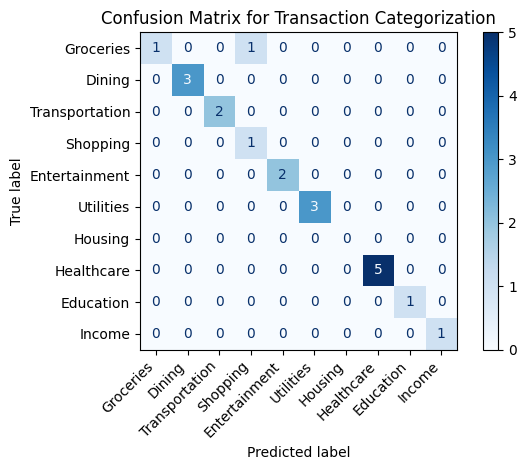

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix
cm = confusion_matrix(sample_df['Category'], sample_df['Predicted_Category'],
                      labels=list(categories.keys()))

# Plot confusion matrix
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(categories.keys()))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Transaction Categorization')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 3. Capability 2: Embeddings for Transaction Similarity

Let's use embeddings to find similar transactions and identify spending patterns.

In [11]:
# Function to get embeddings for transaction descriptions
def get_embedding(text):
    try:
        result = genai.embed_content(
            model=embedding_model,
            content=text,
            task_type="retrieval_document"
        )
        return result['embedding']
    except Exception as e:
        print(f"Error getting embedding: {e}")
        # Return a zero vector as fallback
        return [0] * 768  # Typical embedding dimension

In [12]:
# Get embeddings for all transactions
transaction_texts = [f"{row['Description']} - ${abs(row['Amount']):.2f} {'spent' if row['Amount'] < 0 else 'received'}"
                    for _, row in transactions_df.iterrows()]

# Get embeddings for a subset of transactions to save time
subset_size = 50
subset_df = transactions_df.sample(subset_size, random_state=42).copy()
subset_texts = [f"{row['Description']} - ${abs(row['Amount']):.2f} {'spent' if row['Amount'] < 0 else 'received'}"
               for _, row in subset_df.iterrows()]

# Get embeddings
embeddings = []
for text in subset_texts:
    embedding = get_embedding(text)
    embeddings.append(embedding)

# Store embeddings in the DataFrame
subset_df['Embedding'] = embeddings

In [13]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Function to find similar transactions
def find_similar_transactions(query_text, df, top_n=5):
    # Get embedding for the query
    query_embedding = get_embedding(query_text)

    # Calculate similarity scores
    similarities = []
    for idx, row in df.iterrows():
        similarity = cosine_similarity(
            [query_embedding],
            [row['Embedding']]
        )[0][0]
        similarities.append((idx, similarity))

    # Sort by similarity score
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Return top N similar transactions
    results = []
    for idx, score in similarities[:top_n]:
        row = df.loc[idx]
        results.append({
            'Description': row['Description'],
            'Amount': row['Amount'],
            'Category': row['Category'],
            'Date': row['Date'],
            'Similarity': score
        })

    return results

In [14]:
# Test the similar transaction finder
query = "Coffee shop - $5.50 spent"
similar_transactions = find_similar_transactions(query, subset_df)

print(f"Query: {query}\n")
print("Similar Transactions:")
for i, tx in enumerate(similar_transactions, 1):
    print(f"{i}. {tx['Description']} - ${abs(tx['Amount']):.2f} {'spent' if tx['Amount'] < 0 else 'received'} ({tx['Category']})")
    print(f"   Date: {tx['Date'].strftime('%Y-%m-%d')}, Similarity: {tx['Similarity']:.4f}")

Query: Coffee shop - $5.50 spent

Similar Transactions:
1. Local Restaurant - $31.01 spent (Dining)
   Date: 2025-03-24, Similarity: 0.9346
2. McDonald's - $11.89 spent (Dining)
   Date: 2025-01-26, Similarity: 0.9334
3. Local Restaurant - $35.72 spent (Dining)
   Date: 2025-02-28, Similarity: 0.9317
4. Subway - $54.26 spent (Dining)
   Date: 2025-03-21, Similarity: 0.9270
5. Subway - $35.02 spent (Dining)
   Date: 2025-01-14, Similarity: 0.9228


Let's use embeddings to cluster transactions and identify spending patterns.

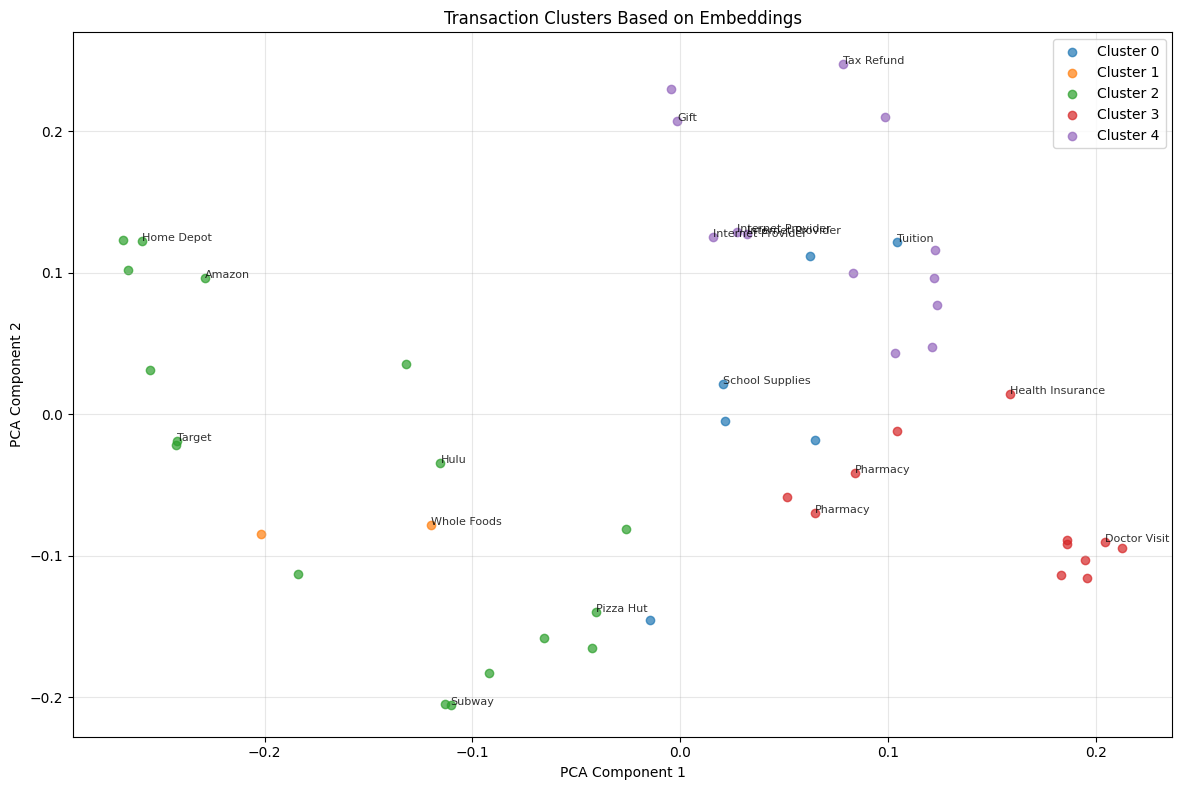

In [15]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Convert embeddings to numpy array
embedding_array = np.array(subset_df['Embedding'].tolist())

# Apply K-means clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
subset_df['Cluster'] = kmeans.fit_predict(embedding_array)

# Apply PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embedding_array)
subset_df['PCA1'] = pca_result[:, 0]
subset_df['PCA2'] = pca_result[:, 1]

# Plot clusters
plt.figure(figsize=(12, 8))
for cluster in range(n_clusters):
    cluster_data = subset_df[subset_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}', alpha=0.7)

    # Add some transaction descriptions as annotations
    for i, (_, row) in enumerate(cluster_data.iterrows()):
        if i % 3 == 0:  # Annotate every 3rd point to avoid clutter
            plt.annotate(row['Description'],
                         (row['PCA1'], row['PCA2']),
                         fontsize=8,
                         alpha=0.8)

plt.title('Transaction Clusters Based on Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Let's analyze each cluster to understand the spending patterns.

In [16]:
# Analyze clusters
for cluster in range(n_clusters):
    cluster_data = subset_df[subset_df['Cluster'] == cluster]

    print(f"\nCluster {cluster} Analysis:")
    print(f"Number of transactions: {len(cluster_data)}")

    # Category distribution
    category_counts = cluster_data['Category'].value_counts()
    print(f"Top categories: {', '.join(category_counts.index[:3])}")

    # Average amount
    avg_amount = cluster_data['Amount'].mean()
    print(f"Average amount: ${avg_amount:.2f}")

    # Sample transactions
    print("Sample transactions:")
    for _, row in cluster_data.head(3).iterrows():
        print(f"  - {row['Description']} (${abs(row['Amount']):.2f}, {row['Category']})")

    # Generate a cluster description using Gemini
    cluster_text = "\n".join([f"{row['Description']} - ${abs(row['Amount']):.2f} - {row['Category']}"
                             for _, row in cluster_data.iterrows()])

    prompt = f"""
    Analyze these transactions and provide a brief 1-2 sentence description of this spending cluster:
    {cluster_text}
    """

    response = model.generate_content(prompt)
    print(f"\nCluster description: {response.text}")
    print("-" * 80)


Cluster 0 Analysis:
Number of transactions: 6
Top categories: Education, Entertainment, Healthcare
Average amount: $-396.29
Sample transactions:
  - School Supplies ($259.42, Education)
  - Gym Membership ($427.87, Healthcare)
  - Movie Theater ($38.77, Entertainment)

Cluster description: This spending cluster reflects a combination of education expenses, healthcare, and leisure activities. The transactions primarily center around educational investments (school supplies, tuition, textbooks) with additions of a gym membership and entertainment options like movies and concerts.

--------------------------------------------------------------------------------

Cluster 1 Analysis:
Number of transactions: 2
Top categories: Groceries
Average amount: $-155.50
Sample transactions:
  - Whole Foods ($162.33, Groceries)
  - Trader Joe's ($148.68, Groceries)

Cluster description: This spending cluster reflects a significant investment in groceries, indicating a focus on food shopping at special

## 4. Capability 3: RAG for Financial Knowledge

Let's implement a Retrieval Augmented Generation (RAG) system to provide evidence-based financial advice.

In [17]:
# Create a knowledge base of financial advice
financial_knowledge = [
    "The 50/30/20 rule suggests allocating 50% of your income to needs, 30% to wants, and 20% to savings and debt repayment.",
    "An emergency fund should ideally cover 3-6 months of essential expenses.",
    "High-interest debt, such as credit card debt, should be prioritized for repayment before investing.",
    "Dollar-cost averaging is an investment strategy where you invest a fixed amount regularly, regardless of market conditions.",
    "A good credit score (above 700) can help you qualify for better interest rates on loans and credit cards.",
    "Diversification in investments helps reduce risk by spreading your money across different asset classes.",
    "Tax-advantaged accounts like 401(k)s and IRAs can help you save for retirement while reducing your tax burden.",
    "Compound interest is the addition of interest to the principal sum of a loan or deposit, resulting in interest earned on interest.",
    "Inflation erodes the purchasing power of money over time, which is why investing is important for long-term financial goals.",
    "A budget is a financial plan that helps you track income and expenses, ensuring you live within your means.",
    "Automating savings and bill payments can help ensure financial consistency and avoid late fees.",
    "The rule of 72 is a simple way to determine how long it will take for an investment to double: divide 72 by the annual rate of return.",
    "Paying yourself first means automatically setting aside a portion of your income for savings before spending on other expenses.",
    "A debt-to-income ratio below 36% is generally considered good for financial health.",
    "Lifestyle inflation occurs when spending increases with income, preventing wealth accumulation despite higher earnings.",
    "Renting can be financially advantageous in certain situations, such as when housing prices are high or when you need flexibility.",
    "Term life insurance is generally more cost-effective than whole life insurance for most people's needs.",
    "A health savings account (HSA) offers triple tax advantages: tax-deductible contributions, tax-free growth, and tax-free withdrawals for qualified medical expenses.",
    "The 4% rule suggests that retirees can withdraw 4% of their retirement savings in the first year, then adjust for inflation each year, with a high probability of not running out of money for at least 30 years.",
    "Zero-based budgeting means allocating every dollar of income to a specific purpose, whether spending, saving, or investing."
]

In [18]:
import chromadb
from chromadb.api import EmbeddingFunction

# Create a ChromaDB client
client = chromadb.Client()

# Create a custom embedding function class
class GenaiEmbeddingFunction(EmbeddingFunction):
    def __call__(self, input):
        embeddings = []
        for text in input:
            embedding = get_embedding(text)
            embeddings.append(embedding)
        return embeddings

# Force a clean start by deleting the collection if it exists
try:
    client.delete_collection(name="financial_knowledge")
    print("Deleted existing collection")
except Exception as e:
    print(f"No existing collection to delete: {str(e)}")

# Create a fresh collection
financial_collection = client.create_collection(
    name="financial_knowledge",
    embedding_function=GenaiEmbeddingFunction()
)
print("Created new collection")

# Add documents to the collection
financial_collection.add(
    documents=financial_knowledge,
    ids=[f"doc_{i}" for i in range(len(financial_knowledge))]
)
print(f"Added {len(financial_knowledge)} documents to collection")



No existing collection to delete: Collection financial_knowledge does not exist.
Created new collection
Added 20 documents to collection


In [19]:
# Function to get financial advice with RAG
def get_financial_advice_with_rag(query, num_results=3):
    # Query the knowledge base
    results = financial_collection.query(
        query_texts=[query],
        n_results=num_results
    )

    # Extract relevant documents
    relevant_docs = results['documents'][0]

    # Create a prompt with the retrieved information
    # Fix: Use proper multi-line f-string without backslashes
    prompt = f"""
    You are a financial advisor providing evidence-based advice. Use the following financial knowledge to answer the question:

    FINANCIAL KNOWLEDGE:
    {chr(10).join([f"- {doc}" for doc in relevant_docs])}

    USER QUESTION: {query}

    Provide a helpful, informative response that directly addresses the question. Include specific advice from the knowledge base and explain why it's relevant. Format your response in markdown.
    """

    # Generate response
    response = model.generate_content(prompt)

    return {
        'response': response.text,
        'sources': relevant_docs
    }


In [20]:
# Test the RAG system with some financial questions
financial_questions = [
    "How should I allocate my monthly income?",
    "What's the best way to save for emergencies?",
    "Should I pay off debt or invest first?"
]

for question in financial_questions:
    print(f"Question: {question}\n")

    result = get_financial_advice_with_rag(question)

    print("Response:")
    display(Markdown(result['response']))

    print("\nSources:")
    for i, source in enumerate(result['sources'], 1):
        print(f"{i}. {source}")

    print("\n" + "-"*80 + "\n")

Question: How should I allocate my monthly income?

Response:


Here's how you can approach allocating your monthly income, based on the provided financial knowledge:

You have a couple of excellent strategies you can use to allocate your monthly income effectively. Both are designed to help you manage your finances and achieve your financial goals.

**1. Zero-Based Budgeting:**

*   **How it works:** With a zero-based budget, you give every dollar you earn a specific job. That means every dollar is either spent, saved, or invested. At the end of the month, your income minus your expenses and savings/investments should equal zero.
*   **Why it's helpful:** This approach is very proactive. It forces you to consider where every dollar is going, preventing impulsive spending and helping you identify areas where you can cut back. It promotes financial discipline.
*   **How to implement it:**
    1.  **List all your income:** Calculate your total monthly income.
    2.  **List all your expenses:** Categorize all your expenses (rent/mortgage, utilities, groceries, transportation, etc.) and estimate the amounts.
    3.  **Allocate remaining funds:** After accounting for expenses, decide how much you will allocate to savings and investments (e.g., emergency fund, retirement accounts). Then, determine any remaining funds to be used for additional investments or wants.
    4.  **Track and adjust:** Regularly track your spending against your budget and make adjustments as needed throughout the month to ensure you stay on track.

**2. The 50/30/20 Rule:**

*   **How it works:** This is a simplified rule of thumb for income allocation.
    *   **50% to Needs:** These are essential expenses, things you *must* pay for (housing, food, transportation, utilities).
    *   **30% to Wants:** These are discretionary expenses, things that aren't essential but you enjoy (entertainment, dining out, hobbies).
    *   **20% to Savings and Debt Repayment:** This is for savings goals (emergency fund, down payment, investments) and paying down any debts you have (credit cards, loans).
*   **Why it's helpful:** It's a straightforward way to allocate your money and ensures you are saving and addressing debt while also allowing yourself some discretionary spending.
*   **How to implement it:**
    1.  **Calculate your income:** Determine your monthly take-home income.
    2.  **Calculate your allocations:** Multiply your income by 0.50 (needs), 0.30 (wants), and 0.20 (savings/debt).
    3.  **Categorize and track:** Track your spending each month, categorizing your expenses to ensure you are staying within the suggested percentages.

**Which approach is right for you?**

*   **Zero-based budgeting** offers the most control and customization. It's great if you want to be extremely detailed and track every dollar.
*   The **50/30/20 rule** provides a good starting point and can be simpler to manage, especially if you are new to budgeting.

**Key Takeaway:** The most important thing is to choose a system and stick to it. Regularly review your budget and adjust it as your income, expenses, and financial goals change.



Sources:
1. Zero-based budgeting means allocating every dollar of income to a specific purpose, whether spending, saving, or investing.
2. A budget is a financial plan that helps you track income and expenses, ensuring you live within your means.
3. The 50/30/20 rule suggests allocating 50% of your income to needs, 30% to wants, and 20% to savings and debt repayment.

--------------------------------------------------------------------------------

Question: What's the best way to save for emergencies?

Response:


The best way to save for emergencies is to build a dedicated emergency fund. Here's how to do it, based on sound financial principles:

*   **Determine Your Target:** Aim to cover 3-6 months of your essential living expenses. This means calculating how much you spend each month on things like housing, food, utilities, transportation, and insurance. This cushion provides a safety net in case of job loss, unexpected medical bills, or major home repairs.

*   **Set Up a Separate Account:** Open a high-yield savings account specifically for your emergency fund. Keep it separate from your regular checking account to prevent you from accidentally spending the money.

*   **Automate Your Savings:** The most effective way to build your emergency fund is to automate your contributions. Set up a recurring transfer from your checking account to your emergency fund savings account each month. This ensures consistency and removes the temptation to skip saving.

*   **Prioritize and Build Gradually:** Start by saving a small amount each month and gradually increase it as your income allows. Even small, consistent contributions can make a significant difference over time. Any unexpected windfalls, like tax refunds, can be added to your emergency fund to accelerate your progress.



Sources:
1. An emergency fund should ideally cover 3-6 months of essential expenses.
2. Automating savings and bill payments can help ensure financial consistency and avoid late fees.
3. Diversification in investments helps reduce risk by spreading your money across different asset classes.

--------------------------------------------------------------------------------

Question: Should I pay off debt or invest first?

Response:


Okay, here's my advice on whether to pay off debt or invest first, based on the provided financial knowledge:

You should **prioritize paying off high-interest debt *before* you begin investing.**

Here's why:

*   **High-Interest Debt is Costly:** As stated in the financial knowledge, high-interest debt, like credit card debt, can quickly accumulate and become a significant financial burden. The interest you pay on this debt is essentially money you're losing.
*   **Beat Inflation:** While investing is crucial to combat inflation and build long-term wealth, you need to stabilize your finances before you make investments. High-interest debt can grow faster than some investments, negating any potential returns you might gain.
*   **Focus on Stability:** Paying down debt improves your overall financial health by reducing your monthly expenses and freeing up cash flow. This creates a more stable foundation for future investing.

**A Practical Approach:**

*   **The 50/30/20 Rule in Action:** Consider using the 50/30/20 rule. Allocate 20% of your income specifically to debt repayment. Use the other 50% for needs and 30% for wants.
*   **Debt Avalanche or Snowball:** Consider using a debt repayment strategy (like the debt avalanche or snowball method) to systematically tackle your debts.

**In summary,** paying off high-interest debt first is generally the more financially sound strategy. Once you've significantly reduced or eliminated your high-interest debt, you can then allocate funds to investments and build towards your long-term financial goals, like retirement or purchasing a home.



Sources:
1. High-interest debt, such as credit card debt, should be prioritized for repayment before investing.
2. The 50/30/20 rule suggests allocating 50% of your income to needs, 30% to wants, and 20% to savings and debt repayment.
3. Inflation erodes the purchasing power of money over time, which is why investing is important for long-term financial goals.

--------------------------------------------------------------------------------



## 5. Capability 4: Function Calling for Financial Calculations

Let's implement function calling to perform financial calculations based on user queries.

In [21]:
# Define financial calculation functions
def calculate_budget_allocation(monthly_income):
    """Calculate budget allocation based on the 50/30/20 rule."""
    needs = monthly_income * 0.5
    wants = monthly_income * 0.3
    savings = monthly_income * 0.2
    return {
        "needs": needs,
        "wants": wants,
        "savings": savings
    }

def calculate_emergency_fund(monthly_expenses, months=6):
    """Calculate recommended emergency fund amount."""
    return monthly_expenses * months

def calculate_debt_payoff(principal, annual_interest_rate, monthly_payment):
    """Calculate time to pay off debt and total interest paid."""
    monthly_rate = annual_interest_rate / 12 / 100
    num_payments = 0
    total_interest = 0
    remaining_balance = principal

    while remaining_balance > 0:
        interest = remaining_balance * monthly_rate
        principal_payment = min(monthly_payment - interest, remaining_balance)

        if monthly_payment <= interest:
            return {
                "months": float('inf'),
                "years": float('inf'),
                "total_interest": float('inf'),
                "error": "Monthly payment too low to cover interest"
            }

        remaining_balance -= principal_payment
        total_interest += interest
        num_payments += 1

        if num_payments > 1200:  # 100 years cap
            break

    return {
        "months": num_payments,
        "years": num_payments / 12,
        "total_interest": total_interest
    }

def calculate_investment_growth(principal, annual_return, years, monthly_contribution=0):
    """Calculate investment growth over time."""
    monthly_rate = annual_return / 12 / 100
    num_months = years * 12
    value = principal

    for _ in range(int(num_months)):
        value = value * (1 + monthly_rate) + monthly_contribution

    return {
        "final_value": value,
        "initial_investment": principal,
        "total_contributions": monthly_contribution * num_months,
        "interest_earned": value - principal - (monthly_contribution * num_months)
    }

def calculate_loan_payment(principal, annual_interest_rate, years):
    """Calculate monthly payment for a loan."""
    monthly_rate = annual_interest_rate / 12 / 100
    num_payments = years * 12

    if monthly_rate == 0:
        monthly_payment = principal / num_payments
    else:
        monthly_payment = principal * (monthly_rate * (1 + monthly_rate) ** num_payments) / ((1 + monthly_rate) ** num_payments - 1)

    total_cost = monthly_payment * num_payments
    total_interest = total_cost - principal

    return {
        "monthly_payment": monthly_payment,
        "total_cost": total_cost,
        "total_interest": total_interest
    }

In [22]:
# Function to parse user queries and call the appropriate financial function
def financial_calculator(query):
    # For google-genai, we need to use a different approach for function calling
    # We'll use a prompt to have the model determine which function to call and with what parameters

    function_descriptions = """
    Available financial calculation functions:

    1. calculate_budget_allocation(monthly_income: float) -> dict
       - Calculates budget allocation based on the 50/30/20 rule
       - Returns: {"needs": float, "wants": float, "savings": float}

    2. calculate_emergency_fund(monthly_expenses: float, months: int = 6) -> float
       - Calculates recommended emergency fund amount
       - Returns: total emergency fund amount

    3. calculate_debt_payoff(principal: float, annual_interest_rate: float, monthly_payment: float) -> dict
       - Calculates time to pay off debt and total interest paid
       - Returns: {"months": int, "years": float, "total_interest": float}

    4. calculate_investment_growth(principal: float, annual_return: float, years: int, monthly_contribution: float = 0) -> dict
       - Calculates investment growth over time
       - Returns: {"final_value": float, "initial_investment": float, "total_contributions": float, "interest_earned": float}

    5. calculate_loan_payment(principal: float, annual_interest_rate: float, years: int) -> dict
       - Calculates monthly payment for a loan
       - Returns: {"monthly_payment": float, "total_cost": float, "total_interest": float}
    """

    prompt = f"""
    You are a financial calculator assistant. Based on the user's query, determine which financial function to call and extract the necessary parameters.

    {function_descriptions}

    User query: {query}

    Respond with a JSON object containing:
    1. "function_name": The name of the function to call
    2. "parameters": An object containing the parameter values
    3. "explanation": A brief explanation of why this function is appropriate

    Only include numeric values for parameters, no text or symbols like $ or %.
    """

    response = model.generate_content(prompt)

    try:
        # Extract JSON from the response
        response_text = response.text
        json_start = response_text.find('{')
        json_end = response_text.rfind('}')
        if json_start != -1 and json_end != -1:
            json_str = response_text[json_start:json_end+1]
            function_call = json.loads(json_str)

            # Call the appropriate function
            function_name = function_call['function_name']
            parameters = function_call['parameters']
            explanation = function_call['explanation']

            if function_name == 'calculate_budget_allocation':
                result = calculate_budget_allocation(**parameters)
            elif function_name == 'calculate_emergency_fund':
                result = calculate_emergency_fund(**parameters)
            elif function_name == 'calculate_debt_payoff':
                result = calculate_debt_payoff(**parameters)
            elif function_name == 'calculate_investment_growth':
                result = calculate_investment_growth(**parameters)
            elif function_name == 'calculate_loan_payment':
                result = calculate_loan_payment(**parameters)
            else:
                return {
                    'error': f"Unknown function: {function_name}",
                    'function_call': function_call
                }

            return {
                'function_name': function_name,
                'parameters': parameters,
                'result': result,
                'explanation': explanation
            }
        else:
            return {
                'error': "Could not parse function call from response",
                'response': response_text
            }
    except Exception as e:
        return {
            'error': str(e),
            'response': response.text
        }

In [23]:

# Test the financial calculator with some queries
financial_queries = [
    "How should I budget my $5000 monthly income?",
    "How much emergency fund do I need if my monthly expenses are $3000?",
    "How long will it take to pay off $10000 credit card debt with 18% interest if I pay $500 monthly?",
    "If I invest $10000 with 8% annual return for 20 years, how much will I have?",
    "What would be my monthly payment for a $300000 mortgage at 4.5% interest for 30 years?"
]

for query in financial_queries:
    print(f"Query: {query}\n")

    result = financial_calculator(query)

    if 'error' in result and 'function_call' not in result:
        print(f"Error: {result['error']}")
        if 'response' in result:
            print(f"Response: {result['response']}")
    else:
        print(f"Function: {result['function_name']}")
        print(f"Parameters: {result['parameters']}")
        print(f"Explanation: {result['explanation']}")
        print("\nResult:")

        # Fix: Check the type of result['result'] before trying to iterate
        if isinstance(result['result'], dict):
            # If result is a dictionary, iterate through its items
            for key, value in result['result'].items():
                if isinstance(value, float):
                    print(f"  {key}: ${value:.2f}")
                else:
                    print(f"  {key}: {value}")
        elif isinstance(result['result'], (int, float)):
            # If result is a number, print it directly
            print(f"  ${result['result']:.2f}")
        else:
            # If result is any other type (like string), print it as is
            print(f"  {result['result']}")

    print("\n" + "-"*80 + "\n")


Query: How should I budget my $5000 monthly income?

Function: calculate_budget_allocation
Parameters: {'monthly_income': 5000}
Explanation: The user is asking about budgeting, and the function 'calculate_budget_allocation' is designed to determine how to allocate income based on the 50/30/20 rule.

Result:
  needs: $2500.00
  wants: $1500.00
  savings: $1000.00

--------------------------------------------------------------------------------

Query: How much emergency fund do I need if my monthly expenses are $3000?

Function: calculate_emergency_fund
Parameters: {'monthly_expenses': 3000}
Explanation: The user is asking about the amount of an emergency fund, and the function calculates the recommended amount based on monthly expenses.

Result:
  $18000.00

--------------------------------------------------------------------------------

Query: How long will it take to pay off $10000 credit card debt with 18% interest if I pay $500 monthly?

Function: calculate_debt_payoff
Parameters:

## 6. Capability 5: Agents with LangGraph for Financial Advisor Workflow

Let's create a conversational financial advisor using LangGraph.

In [24]:
from langchain_core.messages import HumanMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
import operator
from typing import Dict, List, TypedDict, Annotated, Sequence, Literal, Union, Any

In [25]:
# Define the state for our financial advisor agent
class AgentState(TypedDict):
    messages: Annotated[Sequence[Union[HumanMessage, AIMessage]], "The conversation history"]
    next_step: Annotated[str, "The next step in the financial advisor workflow"]
    user_profile: Annotated[Dict, "Information about the user's financial situation"]
    financial_goals: Annotated[List, "The user's financial goals"]
    recommendations: Annotated[List, "Financial recommendations for the user"]

In [42]:
# Initialize the LLM - using Gemini 2.0 Flash-Lite
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",google_api_key=userdata.get("GOOGLE_API_KEY") ,convert_system_message_to_human=True)

In [43]:
# Define the nodes for our financial advisor workflow

# 1. Understand the user's query and determine the next step
def understand_query(state: AgentState) -> AgentState:
    messages = state["messages"]

    # Get the most recent user message
    user_message = messages[-1].content if isinstance(messages[-1], HumanMessage) else ""

    # Determine the next step based on the user's query
    prompt = f"""
    You are a financial advisor assistant. Based on the user's message, determine the next step in the financial advisor workflow.

    User message: {user_message}

    Choose one of the following next steps:
    - gather_information: If the user is new or you need more information about their financial situation
    - identify_goals: If you should help the user identify or clarify their financial goals
    - analyze_finances: If you should analyze the user's financial situation based on information provided
    - provide_recommendations: If you should provide specific financial recommendations
    - answer_question: If the user has a specific financial question that doesn't fit the other categories
    - end_conversation: If the conversation is complete and no further assistance is needed

    Respond with just the next step name, nothing else.
    """

    response = llm.invoke([HumanMessage(content=prompt)])
    next_step = response.content.strip().lower()

    # Validate the next step
    valid_steps = ["gather_information", "identify_goals", "analyze_finances",
                   "provide_recommendations", "answer_question", "end_conversation"]

    if next_step not in valid_steps:
        next_step = "answer_question"  # Default fallback

    return {**state, "next_step": next_step}

# 2. Gather information about the user's financial situation
def gather_information(state: AgentState) -> AgentState:
    messages = state["messages"]
    user_profile = state.get("user_profile", {})

    # Create a prompt to gather financial information
    prompt = f"""
    You are a financial advisor assistant. Your task is to gather important information about the user's financial situation.

    Current conversation:
    {' '.join([f"{'User' if isinstance(m, HumanMessage) else 'Assistant'}: {m.content}" for m in messages])}

    Current user profile information:
    {user_profile}

    Ask thoughtful questions to gather missing information about the user's financial situation. Focus on:
    - Income and expenses
    - Savings and investments
    - Debt and liabilities
    - Financial priorities

    Be conversational and empathetic. Ask one or two questions at a time, not a long list.
    """

    response = llm.invoke([HumanMessage(content=prompt)])

    # Update the messages
    new_messages = messages + [AIMessage(content=response.content)]

    # Extract information from the conversation to update the user profile
    extraction_prompt = f"""
    Based on the conversation so far, extract any financial information about the user and update their profile.

    Current conversation:
    {' '.join([f"{'User' if isinstance(m, HumanMessage) else 'Assistant'}: {m.content}" for m in new_messages])}

    Current user profile:
    {user_profile}

    Extract and update the user profile as a JSON object with any new information. Include all existing information.
    """

    extraction_response = llm.invoke([HumanMessage(content=extraction_prompt)])

    # Try to parse the JSON response
    try:
        # Extract JSON from the response
        response_text = extraction_response.content
        json_start = response_text.find('{')
        json_end = response_text.rfind('}')
        if json_start != -1 and json_end != -1:
            json_str = response_text[json_start:json_end+1]
            updated_profile = json.loads(json_str)
        else:
            updated_profile = user_profile
    except Exception:
        updated_profile = user_profile

    return {**state, "messages": new_messages, "user_profile": updated_profile}

# 3. Identify the user's financial goals
def identify_goals(state: AgentState) -> AgentState:
    messages = state["messages"]
    financial_goals = state.get("financial_goals", [])

    # Create a prompt to identify financial goals
    prompt = f"""
    You are a financial advisor assistant. Your task is to help the user identify and clarify their financial goals.

    Current conversation:
    {' '.join([f"{'User' if isinstance(m, HumanMessage) else 'Assistant'}: {m.content}" for m in messages])}

    Current financial goals:
    {financial_goals}

    Help the user identify specific, measurable, achievable, relevant, and time-bound (SMART) financial goals.
    Ask questions to clarify their priorities, timeframes, and target amounts.

    Be conversational and empathetic. Focus on understanding what's most important to them financially.
    """

    response = llm.invoke([HumanMessage(content=prompt)])

    # Update the messages
    new_messages = messages + [AIMessage(content=response.content)]

    # Extract goals from the conversation
    extraction_prompt = f"""
    Based on the conversation so far, extract the user's financial goals.

    Current conversation:
    {' '.join([f"{'User' if isinstance(m, HumanMessage) else 'Assistant'}: {m.content}" for m in new_messages])}

    Current financial goals:
    {financial_goals}

    Extract and update the financial goals as a JSON array. Each goal should include:
    - description: A clear description of the goal
    - timeframe: When the user wants to achieve this goal
    - amount: The target amount (if applicable)
    - priority: High, medium, or low

    Include all existing goals and add any new ones.
    """

    extraction_response = llm.invoke([HumanMessage(content=extraction_prompt)])

    # Try to parse the JSON response
    try:
        # Extract JSON from the response
        response_text = extraction_response.content
        json_start = response_text.find('[')
        json_end = response_text.rfind(']')
        if json_start != -1 and json_end != -1:
            json_str = response_text[json_start:json_end+1]
            updated_goals = json.loads(json_str)
        else:
            updated_goals = financial_goals
    except Exception:
        updated_goals = financial_goals

    return {**state, "messages": new_messages, "financial_goals": updated_goals}

# 4. Analyze the user's financial situation
def analyze_finances(state: AgentState) -> AgentState:
    messages = state["messages"]
    user_profile = state.get("user_profile", {})
    financial_goals = state.get("financial_goals", [])

    # Create a prompt to analyze the user's financial situation
    prompt = f"""
    You are a financial advisor assistant. Your task is to analyze the user's financial situation based on the information provided.

    User profile:
    {json.dumps(user_profile, indent=2)}

    Financial goals:
    {json.dumps(financial_goals, indent=2)}

    Provide a thoughtful analysis of their financial situation, including:
    1. Income vs. expenses and cash flow
    2. Savings rate and emergency fund adequacy
    3. Debt levels and debt-to-income ratio
    4. Progress toward financial goals
    5. Areas of strength and areas for improvement

    Be specific, data-driven, and actionable in your analysis. Use markdown formatting for readability.
    """

    response = llm.invoke([HumanMessage(content=prompt)])

    # Update the messages
    new_messages = messages + [AIMessage(content=response.content)]

    return {**state, "messages": new_messages}

# 5. Provide financial recommendations
def provide_recommendations(state: AgentState) -> AgentState:
    messages = state["messages"]
    user_profile = state.get("user_profile", {})
    financial_goals = state.get("financial_goals", [])
    recommendations = state.get("recommendations", [])

    # Create a prompt to provide financial recommendations
    prompt = f"""
    You are a financial advisor assistant. Your task is to provide personalized financial recommendations based on the user's situation and goals.

    User profile:
    {json.dumps(user_profile, indent=2)}

    Financial goals:
    {json.dumps(financial_goals, indent=2)}

    Current conversation:
    {' '.join([f"{'User' if isinstance(m, HumanMessage) else 'Assistant'}: {m.content}" for m in messages])}

    Provide 3-5 specific, actionable financial recommendations that will help the user improve their financial situation and progress toward their goals.

    For each recommendation:
    1. Clearly state what they should do
    2. Explain why this recommendation is important
    3. Provide specific steps to implement it
    4. Mention expected outcomes or benefits

    Use markdown formatting for readability. Be specific and personalized, not generic.
    """

    response = llm.invoke([HumanMessage(content=prompt)])

    # Update the messages
    new_messages = messages + [AIMessage(content=response.content)]

    # Extract recommendations from the response
    extraction_prompt = f"""
    Extract the financial recommendations from your response:

    {response.content}

    Format each recommendation as a JSON object with these properties:
    - title: A short title for the recommendation
    - description: The full recommendation text
    - category: The category (e.g., Saving, Investing, Debt, Budget, etc.)
    - priority: High, medium, or low

    Return a JSON array of recommendation objects.
    """

    extraction_response = llm.invoke([HumanMessage(content=extraction_prompt)])

    # Try to parse the JSON response
    try:
        # Extract JSON from the response
        response_text = extraction_response.content
        json_start = response_text.find('[')
        json_end = response_text.rfind(']')
        if json_start != -1 and json_end != -1:
            json_str = response_text[json_start:json_end+1]
            new_recommendations = json.loads(json_str)
            updated_recommendations = recommendations + new_recommendations
        else:
            updated_recommendations = recommendations
    except Exception:
        updated_recommendations = recommendations

    return {**state, "messages": new_messages, "recommendations": updated_recommendations}

# 6. Answer specific financial questions
def answer_question(state: AgentState) -> AgentState:
    messages = state["messages"]
    user_profile = state.get("user_profile", {})

    # Get the most recent user message
    user_message = messages[-1].content if isinstance(messages[-1], HumanMessage) else ""

    # First, try to use RAG to answer the question
    try:
        rag_result = get_financial_advice_with_rag(user_message)
        rag_answer = rag_result['response']
        rag_sources = rag_result['sources']
    except Exception:
        rag_answer = ""
        rag_sources = []

    # Then, try to use function calling for financial calculations
    try:
        calc_result = financial_calculator(user_message)
        if 'error' not in calc_result or 'function_call' in calc_result:
            calc_answer = f"Based on your question, I performed a {calc_result['function_name']} calculation:\n\n"
            for key, value in calc_result['result'].items():
                if isinstance(value, float):
                    calc_answer += f"- {key}: ${value:.2f}\n"
                else:
                    calc_answer += f"- {key}: {value}\n"
        else:
            calc_answer = ""
    except Exception:
        calc_answer = ""

    # Create a prompt to answer the financial question
    prompt = f"""
    You are a financial advisor assistant. Your task is to answer the user's financial question.

    User question: {user_message}

    User profile information:
    {json.dumps(user_profile, indent=2)}

    RAG-based answer:
    {rag_answer}

    RAG sources:
    {rag_sources}

    Calculation result:
    {calc_answer}

    Provide a comprehensive, accurate answer to the user's question. Incorporate the RAG-based information and calculation results if relevant.

    Be specific, educational, and actionable in your response. Use markdown formatting for readability.
    If you're not sure about something, acknowledge the limitations of your knowledge.
    """

    response = llm.invoke([HumanMessage(content=prompt)])

    # Update the messages
    new_messages = messages + [AIMessage(content=response.content)]

    return {**state, "messages": new_messages}

# 7. End the conversation
def end_conversation(state: AgentState) -> AgentState:
    messages = state["messages"]

    # Create a prompt to end the conversation
    prompt = f"""
    You are a financial advisor assistant. The user has indicated they're done with the conversation or you've completed providing assistance.

    Craft a friendly closing message that:
    1. Summarizes the key points discussed
    2. Reminds them of any important next steps
    3. Invites them to return if they have more questions
    4. Wishes them well with their financial journey

    Be warm, professional, and encouraging.
    """

    response = llm.invoke([HumanMessage(content=prompt)])

    # Update the messages
    new_messages = messages + [AIMessage(content=response.content)]

    return {**state, "messages": new_messages}

In [44]:
# Define the router function to determine the next node
def router(state: AgentState) -> str:
    return state["next_step"]

In [45]:
# Create the financial advisor workflow graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("understand_query", understand_query)
workflow.add_node("gather_information", gather_information)
workflow.add_node("identify_goals", identify_goals)
workflow.add_node("analyze_finances", analyze_finances)
workflow.add_node("provide_recommendations", provide_recommendations)
workflow.add_node("answer_question", answer_question)
workflow.add_node("end_conversation", end_conversation)

# Add conditional edge from understand_query using the router function
workflow.add_conditional_edges(
    "understand_query",
    router,  # This router function will determine the next node
    {
        "gather_information": "gather_information",
        "identify_goals": "identify_goals",
        "analyze_finances": "analyze_finances",
        "provide_recommendations": "provide_recommendations",
        "answer_question": "answer_question",
        "end_conversation": "end_conversation"
    }
)

workflow.add_edge("gather_information", "understand_query")
workflow.add_edge("identify_goals", "understand_query")
workflow.add_edge("analyze_finances", "understand_query")
workflow.add_edge("provide_recommendations", "understand_query")
workflow.add_edge("answer_question", "understand_query")
workflow.add_edge("end_conversation", END)

# Set the entry point
workflow.set_entry_point("understand_query")

# Compile the graph
financial_advisor = workflow.compile()



In [46]:
# Function to interact with the financial advisor
def chat_with_financial_advisor(user_input, state=None):
    if state is None:
        # Initialize state
        state = {
            "messages": [],
            "next_step": "",
            "user_profile": {},
            "financial_goals": [],
            "recommendations": []
        }

    # Add user message to state
    state["messages"].append(HumanMessage(content=user_input))

    # Run the workflow
    result = financial_advisor.invoke(state)

    # Return the updated state and the last assistant message
    last_message = result["messages"][-1].content if result["messages"] else ""
    return result, last_message

In [47]:
# Create an interactive demo using IPython widgets
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create widgets
output = widgets.Output()
text_input = widgets.Text(description="Your message:", placeholder="Type your financial question here", layout=widgets.Layout(width='80%'))
send_button = widgets.Button(description="Send")
reset_button = widgets.Button(description="Reset Conversation")

# Initialize state
advisor_state = {
    "messages": [],
    "next_step": "",
    "user_profile": {},
    "financial_goals": [],
    "recommendations": []
}

# Define button click handlers
def on_send_button_clicked(b):
    global advisor_state
    user_input = text_input.value
    if not user_input.strip():
        return

    text_input.value = ""

    with output:
        display(widgets.HTML(f"<b>You:</b> {user_input}"))

        # Show thinking indicator
        thinking = widgets.HTML("<i>FinGenius is thinking...</i>")
        display(thinking)

        # Process the input
        advisor_state, response = chat_with_financial_advisor(user_input, advisor_state)

        # Remove thinking indicator and display response
        thinking.close()
        display(widgets.HTML(f"<b>FinGenius:</b> {response}"))

def on_reset_button_clicked(b):
    global advisor_state
    advisor_state = {
        "messages": [],
        "next_step": "",
        "user_profile": {},
        "financial_goals": [],
        "recommendations": []
    }

    with output:
        clear_output()
        display(widgets.HTML("<i>Conversation reset. How can I help with your finances today?</i>"))

# Connect handlers to buttons
send_button.on_click(on_send_button_clicked)
reset_button.on_click(on_reset_button_clicked)

# Handle Enter key in text input
def on_enter(sender):
    on_send_button_clicked(None)

text_input.on_submit(on_enter)

# Create layout
input_box = widgets.HBox([text_input, send_button, reset_button])
dashboard = widgets.VBox([widgets.HTML("<h3>FinGenius: AI Personal Finance Advisor</h3>"), output, input_box])

# Initialize the chat
with output:
    display(widgets.HTML("<i>Hello! I'm FinGenius, your AI personal finance advisor. How can I help you today?</i>"))

# Display the dashboard
display(dashboard)

## Conclusion

In this project, we've built FinGenius, an AI-powered personal finance advisor that demonstrates multiple Gen AI capabilities:

1. **Structured Output/JSON Mode**: We used structured output to categorize financial transactions and extract financial information in a consistent format.

2. **Embeddings**: We leveraged embeddings to find similar transactions and cluster spending patterns, providing insights into financial behavior.

3. **RAG (Retrieval Augmented Generation)**: We implemented a knowledge base of financial advice and used RAG to provide evidence-based financial recommendations.

4. **Function Calling**: We created financial calculation functions and used function calling to perform calculations based on user queries.

5. **Agents with LangGraph**: We built a conversational financial advisor workflow using LangGraph, enabling a structured approach to financial guidance.

### Real-World Applications

This project has numerous real-world applications:

- **Personal Finance Management**: Helping individuals understand their spending patterns and make better financial decisions.
- **Financial Education**: Providing accessible financial knowledge and advice to those without access to professional advisors.
- **Banking and Fintech**: Enhancing customer experience with AI-powered financial guidance.
- **Financial Inclusion**: Making financial advice accessible to underserved populations.

### Limitations and Future Improvements

While FinGenius demonstrates powerful capabilities, it has several limitations:

1. **Data Privacy and Security**: A production version would need robust security measures for handling sensitive financial data.
2. **Regulatory Compliance**: Financial advice is regulated in many jurisdictions, requiring careful implementation.
3. **Model Limitations**: The underlying models may not always provide accurate financial advice or calculations.
4. **Limited Financial Knowledge**: The knowledge base is small and would need expansion for comprehensive coverage.

Future improvements could include:

- Integration with real financial data sources (banks, credit cards, investment accounts)
- More sophisticated financial planning algorithms
- Expanded knowledge base covering more financial topics
- Fine-tuning models specifically for financial advice
- Adding visualization capabilities for financial projections
- Implementing user authentication and data encryption

### Final Thoughts

FinGenius demonstrates how Gen AI capabilities can be combined to create a powerful, practical application that addresses a real-world need. By leveraging structured output, embeddings, RAG, function calling, and agent workflows, we've created a system that can help users understand their finances, set goals, and make better financial decisions.

As Gen AI technology continues to advance, applications like FinGenius will become increasingly sophisticated and valuable, potentially democratizing access to high-quality financial advice and improving financial outcomes for millions of people.